In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Funzione per filtrare le linee basate sull'orientamento e posizione
def filter_lines(lines, orientation='horizontal', threshold=10):
    filtered_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if orientation == 'horizontal' and abs(y1 - y2) < threshold:
            filtered_lines.append(line)
        elif orientation == 'vertical' and abs(x1 - x2) < threshold:
            filtered_lines.append(line)
    return filtered_lines

In [4]:
# Funzione per trovare l'intersezione tra due linee
def line_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return None  # Le linee sono parallele

    px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

    return int(px), int(py)

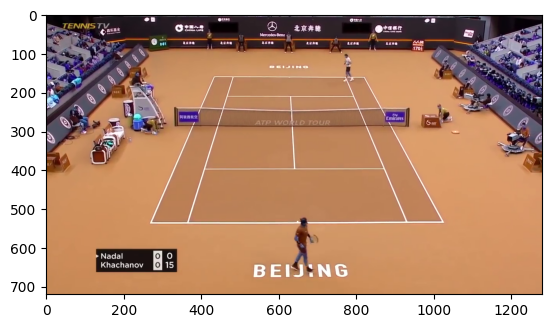

In [5]:
# Load the image
image = cv2.imread('input_image9.png', cv2.IMREAD_COLOR)

plt.imshow(image)
plt.show()

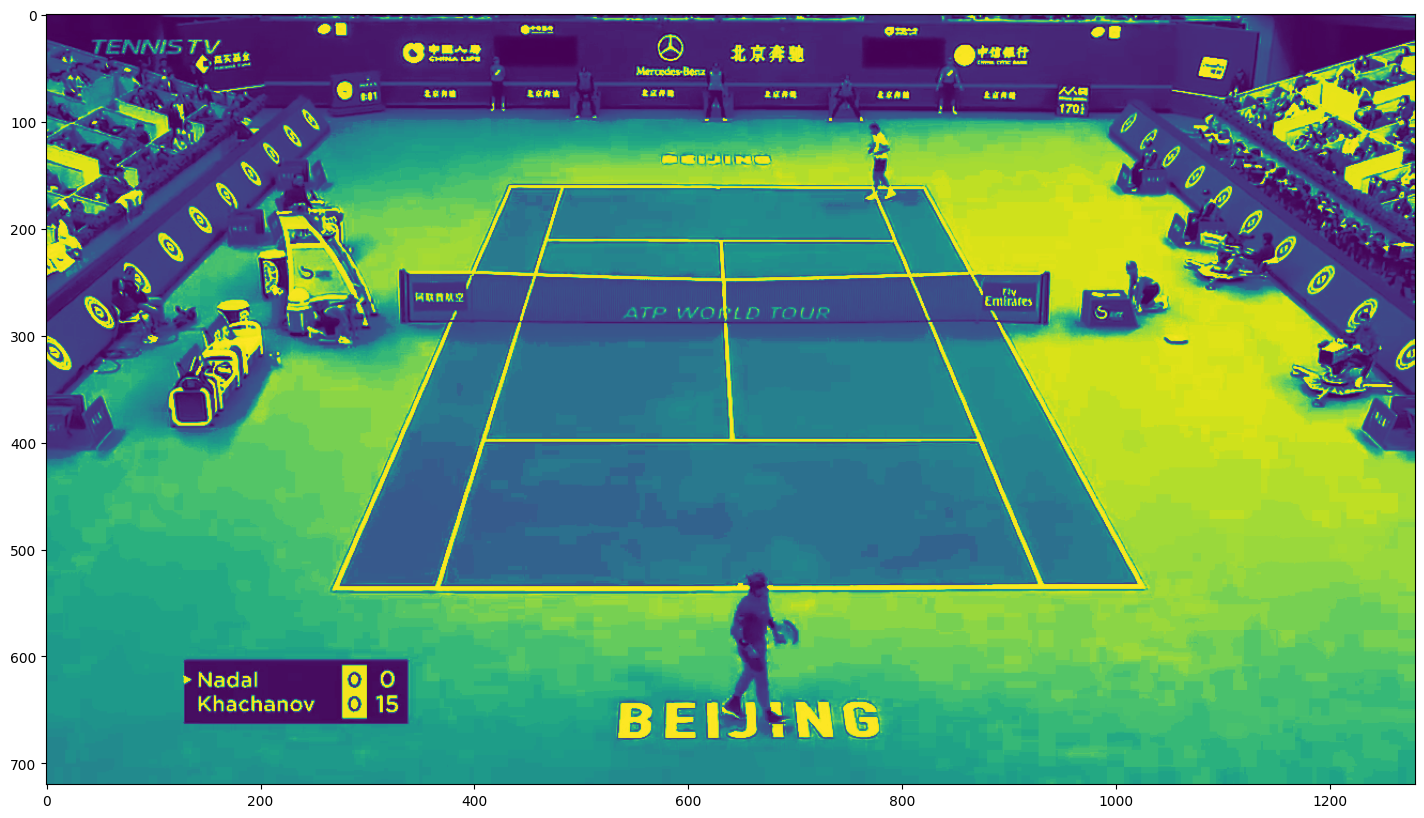

In [6]:
# Converti l'immagine in scala di grigi
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Applica l'equalizzazione dell'istogramma
equalized_image = cv2.equalizeHist(gray)

plt.figure(figsize=(20, 10))
plt.imshow(equalized_image)
plt.show()

In [7]:
# Apply Canny edge detection
edges = cv2.Canny(equalized_image, 100, 200)
type(edges)

numpy.ndarray

(-0.5, 1279.5, 719.5, -0.5)

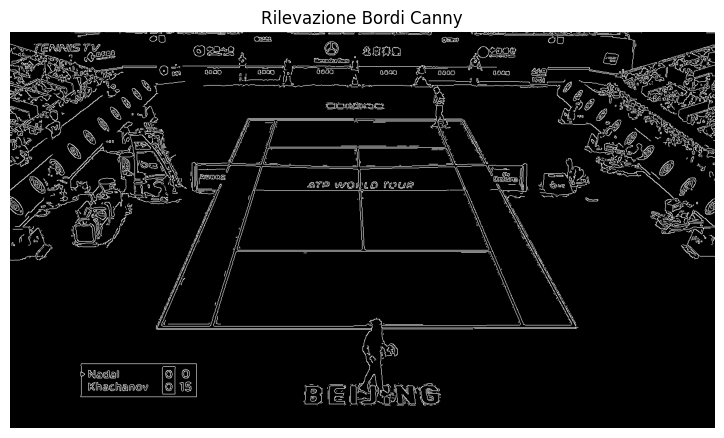

In [8]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 2)
plt.title('Rilevazione Bordi Canny')
plt.imshow(edges, cmap='gray', vmin='0', vmax='255' )
plt.axis('off')  # Nasconde gli assi

In [9]:
# Trova i contorni
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Seleziona il contorno più grande (assumendo che sia il campo da tennis)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    contour_image = image.copy()
    cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 2)
else:
    largest_contour = []

In [10]:
# Applica la trasformata di Hough per rilevare le linee
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)
type(lines)

numpy.ndarray

In [11]:
# Crea una copia dell'immagine originale per disegnare le linee
line_image = image.copy()

In [12]:
# Disegna le linee rilevate sull'immagine
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

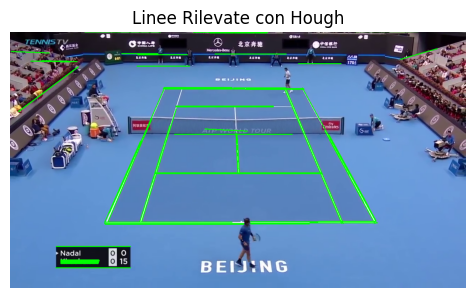

In [13]:
# Aumenta la dimensione della figura
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 3)
plt.title('Linee Rilevate con Hough')
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [132]:
if lines is not None:
    # Filtra le linee orizzontali e verticali
    horizontal_lines = filter_lines(lines, orientation='horizontal')
    vertical_lines = filter_lines(lines, orientation='vertical')

    # Filtra ulteriormente le linee che non sono vicine al contorno
    perimeter_lines = []
    for line in horizontal_lines + vertical_lines:
        x1, y1, x2, y2 = line[0]
        distance1 = cv2.pointPolygonTest(largest_contour, (x1, y1), True)
        distance2 = cv2.pointPolygonTest(largest_contour, (x2, y2), True)
        if distance1 > -10 and distance2 > -10:  # Filtra le linee che sono all'interno o molto vicine al contorno
            perimeter_lines.append(line)
# Disegna le linee perimetrali filtrate
    for line in perimeter_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
# Trova le intersezioni tra le linee orizzontali e verticali
intersections = []
for h_line in filter_lines(perimeter_lines, orientation='horizontal'):
    for v_line in filter_lines(perimeter_lines, orientation='vertical'):
        intersection = line_intersection(h_line[0], v_line[0])
        if intersection is not None:
            intersections.append(intersection)

# Filtra le intersezioni per rimuovere quelle esterne al campo
intersections = [pt for pt in intersections if 0 <= pt[0] < image.shape[1] and 0 <= pt[1] < image.shape[0]]
 # Disegna le intersezioni (keypoints) sull'immagine
for pt in intersections:
    cv2.circle(line_image, pt, 5, (0, 0, 255), -1)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'pointPolygonTest'
> Overload resolution failed:
>  - Can't parse 'pt'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt'. Sequence item with index 0 has a wrong type


(-0.5, 1279.5, 719.5, -0.5)

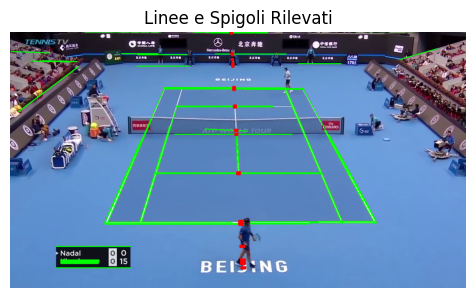

In [122]:
# Aumenta la dimensione della figura
plt.figure(figsize=(20, 10))

# Visualizza l'immagine con le linee e gli spigoli rilevati
plt.subplot(1, 3, 3)
plt.title('Linee e Spigoli Rilevati')
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')